## Initialization of random Generator

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1976)
tf.random.set_seed(1976)

## Definition of cost function and constraint
Here, we use a system call to run Igloo code from a shell script. Note that input / output files are employed to transfer design vector and observation values.

In [2]:
import subprocess

dim = 3

class Sim:
    
    threshold = 0.5

    @staticmethod
    def objective(input_data):
        
        x = input_data[:]
        size = x.get_shape()[0]
        sim_value = np.zeros(size)
        
        for i in range(size):
        
            f_out = open("design_vector_0.dat", "w")
            f_out.write(str(dim))
            f_out.write("\n")
            np.savetxt(f_out, x[i])
            f_out.close()
        
            subprocess.run(["./run.sh"])
        
            f_in = open("simulation_result_0.dat", "r")
            line1 = f_in.readline()
            line2 = f_in.readline()
            line3 = f_in.readline()
            sim_number = int(line1)
            sim_flag = int(line2)
            sim_value[i] = float(line3)
        
        return sim_value[:, None]
    
    @staticmethod
    def constraint(input_data):
        
        x = input_data[:]
        size = x.get_shape()[0]
        const_value = np.zeros(size)
        
        for i in range(size):
        
            const_value[i] = x[i,1]
        
        return const_value[:, None]


## Optimization settings
We start by defining the search space.

In [3]:
import trieste
from trieste.space import Box

search_space = trieste.space.Box(
    [0.1, 0.01, -0.1],
    [3.0, 1.00, 2.0]
)

2022-05-17 10:05:28.093533: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We define now the Trieste observer to get cost function and constraint values from a set of design vectors. 

In [4]:
from trieste.data import Dataset

OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"

def observer(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim.objective(query_points)),
        CONSTRAINT: Dataset(query_points, Sim.constraint(query_points)),
    }

Then, we define a Design of Experiment based on random distribution.

In [13]:
num_initial_points = 12
initial_query_points = search_space.sample(num_initial_points)
print(f"DoE points: \n {initial_query_points[:, :]}")

DoE points: 
 [[2.04057017 0.34366161 0.29009292]
 [0.22094017 0.10725021 1.8697245 ]
 [2.7186466  0.11732994 1.94172695]
 [2.84226373 0.87477952 0.3594007 ]
 [1.15357502 0.30124132 0.25375663]
 [2.65906286 0.76885335 1.24175559]
 [1.70529364 0.63185991 1.1987886 ]
 [2.82297322 0.27809821 0.8614327 ]
 [1.89762192 0.75236526 0.53135677]
 [2.718774   0.68769465 1.71830445]
 [1.69852718 0.92287624 1.60924459]
 [0.36853191 0.67437126 0.09537404]]


We compute the observation values using the simulator.

In [14]:
initial_data = observer(initial_query_points)

> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done


## Bayesian optimization
We start by constructing the GP model based on the Design of Experiment observations.

In [15]:
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression


def create_bo_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr)


initial_models = trieste.utils.map_values(create_bo_model, initial_data)

We define now the acquisition function used to drive the Bayesian optimization. Here we use the Expected Improvement criterion associated to the Probability of Feasibility criterion for the constraint. Note that the constraint threshold is used as argument.

In [16]:
from trieste.acquisition.rule import EfficientGlobalOptimization

pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    OBJECTIVE, pof.using(CONSTRAINT)
)
rule = EfficientGlobalOptimization(eci)

Now we cam solve the optimization problem.

In [17]:
num_steps = 40
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

data = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluation done
> evaluation starts ...
> evaluati

## Analysis of the results
First we plot the evolution of the cost function and constraint values.

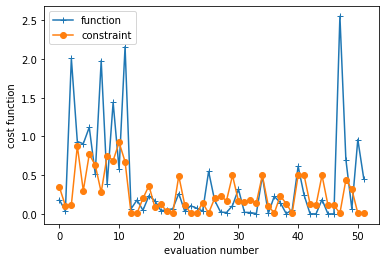

In [18]:
from matplotlib import pyplot;

pyplot.plot(data[OBJECTIVE].observations[:], label="function", marker="+");
pyplot.plot(data[CONSTRAINT].observations[:], label="constraint", marker="o");
pyplot.xlabel("evaluation number");
pyplot.ylabel("cost function");
pyplot.legend();
pyplot.show();

Second we plot the evolution of the three design variables.

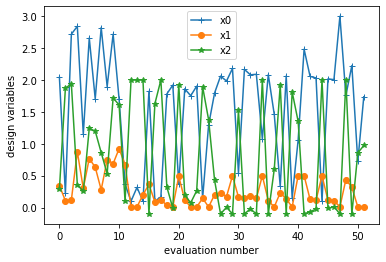

In [20]:
pyplot.plot(data[OBJECTIVE].query_points[:,0], label="x0", marker="+");
pyplot.plot(data[OBJECTIVE].query_points[:,1], label="x1", marker="o");
pyplot.plot(data[OBJECTIVE].query_points[:,2], label="x2", marker="*");
pyplot.xlabel("evaluation number");
pyplot.ylabel("design variables");
pyplot.legend();
pyplot.show();

Finally, we get the best point.

In [19]:
query_points = data[OBJECTIVE].query_points.numpy()
observations = data[OBJECTIVE].observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

query point: [ 2.01778678  0.11310889 -0.01453995]
observation: [0.00042421]
